In [16]:
!pip install segmentation-models-pytorch

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [18]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


##  1) Load a pretrained model

In [19]:
model = smp.Unet(
    encoder_name="resnet18",
    # encoder_weights= "imagenet", # Removed to avoid conflict with in_channels=2
    in_channels=3,
    classes=1,
    decoder_attention_type=None,
    decoder_use_batchnorm=False
)

## 2) Fine - tuning the Model

In [20]:
class TrainDataset(Dataset):

  def __init__(self,pictures_path, transform = None):
    if isinstance(pictures_path, str):
      pictures_path = [pictures_path]
    self.pictures_path = pictures_path
    self.transform = transform
    self.data = None

  def __len__(self):
    return len(self.pictures_path)

  def __getitem__(self,idx):
    self.data = Image.open(self.pictures_path[idx]).convert("RGB")
    if self.transform:
      self.data = self.transform(self.data)
    return self.data


In [21]:
def getting_pictures_path(path_folder):
  path_pictures = [os.path.join(path_folder, folder) for folder in os.listdir(path_folder) if not folder.startswith(".")]
  return path_pictures

pictures_path = getting_pictures_path("/content/drive/MyDrive/Dataset/transistor/train/good")
print(pictures_path)

['/content/drive/MyDrive/Dataset/transistor/train/good/028.png', '/content/drive/MyDrive/Dataset/transistor/train/good/031.png', '/content/drive/MyDrive/Dataset/transistor/train/good/022.png', '/content/drive/MyDrive/Dataset/transistor/train/good/036.png', '/content/drive/MyDrive/Dataset/transistor/train/good/007.png', '/content/drive/MyDrive/Dataset/transistor/train/good/000.png', '/content/drive/MyDrive/Dataset/transistor/train/good/008.png', '/content/drive/MyDrive/Dataset/transistor/train/good/032.png', '/content/drive/MyDrive/Dataset/transistor/train/good/001.png', '/content/drive/MyDrive/Dataset/transistor/train/good/003.png', '/content/drive/MyDrive/Dataset/transistor/train/good/025.png', '/content/drive/MyDrive/Dataset/transistor/train/good/038.png', '/content/drive/MyDrive/Dataset/transistor/train/good/006.png', '/content/drive/MyDrive/Dataset/transistor/train/good/020.png', '/content/drive/MyDrive/Dataset/transistor/train/good/034.png', '/content/drive/MyDrive/Dataset/transis

In [22]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [23]:
model.eval()
dummy_input = torch.randn(1, 3, 256, 256)  # batch=1, 3 canaux, 256x256
output = model(dummy_input)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 256, 256])


In [24]:
criterion = nn.MSELoss()
path_train = "/content/drive/MyDrive/Dataset/transistor/train/good"
transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomRotation(10),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

dataset = TrainDataset(pictures_path=pictures_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

print(dataset.pictures_path)

batch = next(iter(dataloader))
print(batch[0])

['/content/drive/MyDrive/Dataset/transistor/train/good/028.png', '/content/drive/MyDrive/Dataset/transistor/train/good/031.png', '/content/drive/MyDrive/Dataset/transistor/train/good/022.png', '/content/drive/MyDrive/Dataset/transistor/train/good/036.png', '/content/drive/MyDrive/Dataset/transistor/train/good/007.png', '/content/drive/MyDrive/Dataset/transistor/train/good/000.png', '/content/drive/MyDrive/Dataset/transistor/train/good/008.png', '/content/drive/MyDrive/Dataset/transistor/train/good/032.png', '/content/drive/MyDrive/Dataset/transistor/train/good/001.png', '/content/drive/MyDrive/Dataset/transistor/train/good/003.png', '/content/drive/MyDrive/Dataset/transistor/train/good/025.png', '/content/drive/MyDrive/Dataset/transistor/train/good/038.png', '/content/drive/MyDrive/Dataset/transistor/train/good/006.png', '/content/drive/MyDrive/Dataset/transistor/train/good/020.png', '/content/drive/MyDrive/Dataset/transistor/train/good/034.png', '/content/drive/MyDrive/Dataset/transis

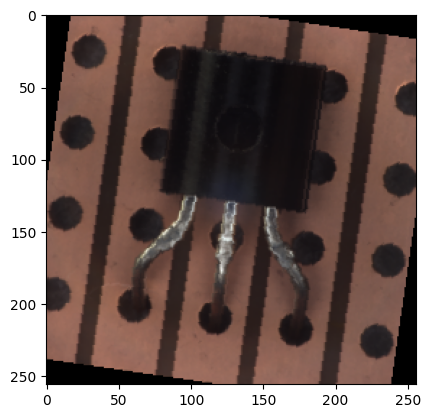

In [25]:
np_arr = np.array(batch[0])
np_arr = np.transpose(np_arr, (1, 2, 0))
plt.subplot()
plt.imshow(np_arr)
plt.show()

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [27]:

optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 50
for epoch in range(epochs):
    for images in dataloader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([8, 3, 256, 256])) that is different to the input size (torch.Size([8, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([5, 3, 256, 256])) that is different to the input size (torch.Size([5, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.020969878882169724
Epoch 2, Loss: 0.013516750186681747
Epoch 3, Loss: 0.011421140283346176
Epoch 4, Loss: 0.010754631832242012
Epoch 5, Loss: 0.009285526350140572
Epoch 6, Loss: 0.008726726286113262
Epoch 7, Loss: 0.00801159255206585
Epoch 8, Loss: 0.007747795898467302
Epoch 9, Loss: 0.007909148000180721
Epoch 10, Loss: 0.007209215313196182
Epoch 11, Loss: 0.007312325295060873
Epoch 12, Loss: 0.007473868317902088
Epoch 13, Loss: 0.006693084724247456
Epoch 14, Loss: 0.006882021203637123
Epoch 15, Loss: 0.0076813045889139175
Epoch 16, Loss: 0.006332427263259888
Epoch 17, Loss: 0.006785193458199501
Epoch 18, Loss: 0.00795701052993536
Epoch 19, Loss: 0.006893474142998457
Epoch 20, Loss: 0.006229029502719641
Epoch 21, Loss: 0.007157695945352316
Epoch 22, Loss: 0.006280128378421068
Epoch 23, Loss: 0.006898917723447084
Epoch 24, Loss: 0.006730576511472464
Epoch 25, Loss: 0.006815015338361263
Epoch 26, Loss: 0.006520030088722706
Epoch 27, Loss: 0.006194326560944319
Epoch 28, L

## 3) Testing the model

#### A) One Picture Test

In [28]:
# 1. Charger une image depuis un chemin
def load_image_from_path(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Ajoute une dimension batch

# 2. Définir la transformation (doit correspondre à celle utilisée pour l'entraînement)
transform = T.Compose([
    T.Resize((256, 256)),  # Ajuste selon ta taille d'entrée
    T.ToTensor(),
    # Ajoute d'autres transformations si nécessaire (normalisation, etc.)
])

# 3. Charger et tester le modèle
model.eval()  # Mets le modèle en mode évaluation
with torch.no_grad():
    test_image = load_image_from_path("/content/drive/MyDrive/Dataset/transistor/test/bent_lead/000.png", transform).to(device)
    output = model(test_image)

    # Si tu veux visualiser le résultat
output_image = output.squeeze().cpu().numpy()  # Supprime la dimension batch et déplace sur CPU



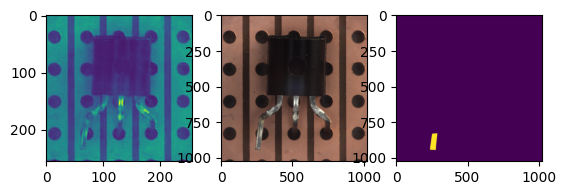

In [29]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(output_image)
ax[1].imshow(Image.open("/content/drive/MyDrive/Dataset/transistor/test/bent_lead/000.png"))
ax[2].imshow(Image.open("/content/drive/MyDrive/Dataset/transistor/ground_truth/bent_lead/000_mask.png"))
plt.show()

#### B) Batch Test

### Preparing the dataset for testing

In [ ]:
path_test = "/content/drive/MyDrive/Dataset/transistor/test"
path_folder = [folder for folder in os.listdir(path_test) if not folder.startswith(".")]
good_folder = path_folder[4]
good_pictures = [
                os.path.join(path_test, good_folder, pictures)
                for pictures in os.listdir(os.path.join(path_test, good_folder))
                ]
print(len(good_pictures))


In [ ]:
first_good_picture_path = good_pictures[0]
opened_good_image = Image.open(first_good_picture_path).convert("RGB")
mask_empty_255 = np.ones((opened_good_image.height, opened_good_image.width), dtype=np.uint8) * 255
batch_mask = [Image.fromarray(mask_empty_255) for x in range(len(good_pictures))]
print(len(batch_mask))

In [ ]:
first_good_picture_path = good_pictures[0]
opened_good_image = Image.open(first_good_picture_path).convert("RGB")
mask_empty_255 = np.ones((opened_good_image.height, opened_good_image.width), dtype=np.uint8) * 255
batch_mask = [Image.fromarray(mask_empty_255) for x in range(len(good_pictures))]
for i,j in enumerate(batch_mask):
  j.save(f'/content/drive/MyDrive/Dataset/transistor/ground_truth/good/{i}.jpg')

In [ ]:
pictures_test = [
    os.path.join(path_test, folder, picture)
    for folder in path_folder
    for picture in os.listdir(os.path.join(path_test, folder))
    if picture.lower().endswith(('.png', '.jpg', '.jpeg'))
]

In [ ]:
path_mask = "/content/drive/MyDrive/Dataset/transistor/ground_truth"
path_folder = [folder for folder in os.listdir(path_mask) if not folder.startswith(".")]
mask = [
    os.path.join(path_mask, folder, picture)
    for folder in path_folder
    for picture in os.listdir(os.path.join(path_mask, folder))
    if picture.lower().endswith(('.png', '.jpg', '.jpeg'))
]

In [ ]:
image_paths = sorted(pictures_test)
mask_paths = sorted(mask)
print(len(image_paths), len(mask_paths))
assert len(image_paths) == len(mask_paths), "Nombre d'images et de masques différents"

In [ ]:
class TestTransistorDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Charger image
        img = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Transformer
        if self.img_transform:
            img = self.img_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return img, mask

In [ ]:
print(image_paths[20])
print(mask_paths[20])
fig,ax = plt.subplots(1,2)
ax[0].imshow(Image.open(image_paths[20]))
ax[1].imshow(Image.open(mask_paths[20]))
plt.show()

In [ ]:
img_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

mask_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

dataset_test = TestTransistorDataset(
    image_paths=pictures_test,
    mask_paths=mask,
    img_transform=img_transform,
    mask_transform=mask_transform
)

dataloader_test = DataLoader(dataset_test, batch_size=4, shuffle=False)

In [ ]:
imgs, masks = next(iter(dataloader_test))
print(imgs.shape)  # torch.Size([4, 3, 256, 256])
print(masks.shape)

In [ ]:
model.eval()# mets le models en test

all_scores = []
all_gt_labels = []

with torch.no_grad():
    for imgs, gt_masks in dataloader_test:
        imgs = imgs.to(device)
        gt_masks = gt_masks.to(device)

        recon = torch.sigmoid(model(imgs)) # reconstruction de l'image
        error_map = (imgs - recon).abs().mean(dim=1)  # (B,H,W)

        # image-level score
        scores = error_map.view(error_map.size(0), -1).max(dim=1).values

        # ground truth image-level
        gt_labels = (gt_masks.view(gt_masks.size(0), -1).sum(dim=1) > 0).int()

        all_scores.extend(scores.cpu().numpy())
        all_gt_labels.extend(gt_labels.cpu().numpy())

In [ ]:

# Définir un seuil pour détecter un défaut
threshold = np.mean(all_scores) + 3*np.std(all_scores)  # ou percentile 95

# prédiction image-level
all_pred_labels = (np.array(all_scores) > threshold).astype(int)

# Classification report
print(classification_report(all_gt_labels, all_pred_labels))

# Confusion matrix
cm = confusion_matrix(all_gt_labels, all_pred_labels)
print("Confusion Matrix:\n", cm)


In [ ]:
threshold = 0.24 # à ajuster
folder_name = "bent_lead"

for i in range(0,10):
  num_pictures = f"00{i}"
  mask_test = f'/content/drive/MyDrive/Dataset/transistor/ground_truth/{folder_name}/{num_pictures}_mask.png'
  image_test = f"/content/drive/MyDrive/Dataset/transistor/test/{folder_name}/{num_pictures}.png"

  mask = Image.open(mask_test).convert("L")
  mask = mask_transform(mask)
  mask = mask.unsqueeze(0)
  mask = mask.to(device)
  img = Image.open(image_test).convert("RGB")
  img = transform(img)
  img = img.unsqueeze(0)
  img = img.to(device)
  with torch.no_grad():
      output = model(img)

  error_map = (img - output).abs().mean(dim=1)  # (1, H, W)
  pred_mask = (error_map > threshold).float()

  fig,ax = plt.subplots(1,4)
  ax[0].imshow(Image.open(image_test))
  ax[0].set_title("Original")
  ax[1].imshow(Image.open(mask_test))
  ax[1].set_title("Ground Truth")
  ax[2].imshow(output.squeeze().cpu(), cmap='gray')
  ax[2].set_title("Reconstructed")
  ax[3].imshow(pred_mask.squeeze().cpu(), cmap='gray')
  ax[3].set_title("Prediction")
  plt.show()


